## Ансамбли и полносвязные нейронные сети
В этом ноутбуке вам нужно обучить модели на датасете классификации из предыдущего ноутбука и сравнить результаты. Вам будет предоставлен baseline, на основе которого вы будете доделывать предсказывающие модели. Оценка лабы будет зависеть от ROC-AUC на тестовых данных по следующим критериям:
\
AUC - на тестовых данных
- $AUC \leq 0.76$ - 0 баллов
- $0.76 < AUC \leq 0.77$ - 2 балла
- $0.77 < AUC \leq 0.78$ - 4 балла
- $0.78 < AUC \leq 0.79$ - 6 баллов
- $0.79 < AUC \leq 0.80$ - 8 баллов
- $AUC > 0.80$ - 10 баллов


In [1]:
!pip install optuna


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import roc_auc_score, precision_score, recall_score, roc_curve, accuracy_score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv('german.csv', sep=';')
data = data.drop('Foreign_Worker', axis=1)

X = data.iloc[:, 1:]
y = data.iloc[:, 0]

missing_values_count = X.isnull().sum()
X_cleaned = X.dropna() if missing_values_count.sum() < len(X) * 0.05 else X.fillna(X.median())

Q1 = X_cleaned.quantile(0.25)
Q3 = X_cleaned.quantile(0.75)
IQR = Q3 - Q1

mask = ~((X_cleaned < (Q1 - 1.5 * IQR)) | (X_cleaned > (Q3 + 1.5 * IQR))).any(axis=1)
X_no_outliers = X_cleaned[mask]
y_no_outliers = y[mask]

X_train, X_test, y_train, y_test = train_test_split(X_no_outliers, y_no_outliers, test_size=0.2, random_state=42)

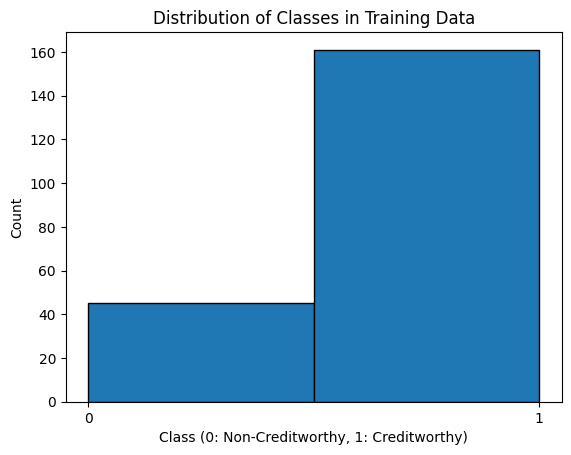

In [4]:
plt.hist(y_train, bins=2, edgecolor='k')
plt.xticks([0, 1])
plt.xlabel('Class (0: Non-Creditworthy, 1: Creditworthy)')
plt.ylabel('Count')
plt.title('Distribution of Classes in Training Data')
plt.show()

In [5]:
#масштабируем данные
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
import optuna

c:\Users\owner\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
#оптимизируем гиперпараметры
import optuna


def objective_gbc(trial):
    n_estimators = trial.suggest_int('n_estimators', 1, 200)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 10.0, log=True)
    max_depth = trial.suggest_int('max_depth', 1, 500)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 200)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 100)

    model = GradientBoostingClassifier(max_depth=max_depth,
                                   min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf,
                                   n_estimators = n_estimators,
                                    learning_rate = learning_rate)
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    roc_auc = roc_auc_score(y_test, y_pred)
    return roc_auc


def objective_mlp(trial):
    hidden_layer_sizes = trial.suggest_int('hidden_layer_sizes ', 2, 1000)
    max_iter = trial.suggest_int('max_iter', 100, 1000)

    model = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        max_iter=max_iter
    )
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    roc_auc = roc_auc_score(y_test, y_pred)
    return roc_auc


study_gbc = optuna.create_study(direction='maximize')
study_gbc.optimize(objective_gbc, n_trials=50)

print("Best ROC-AUC for GradientBoostingClassifier: ", study_gbc.best_value)
print("Best hyperparameters for GradientBoostingClassifier: ", study_gbc.best_params)


study_mlp = optuna.create_study(direction='maximize')
study_mlp.optimize(objective_mlp, n_trials=25)

print("Best ROC-AUC for MLPClassifier: ", study_mlp.best_value)
print("Best hyperparameters for MLPClassifier: ", study_mlp.best_params)

[I 2024-10-31 22:43:06,229] A new study created in memory with name: no-name-92cdb914-592e-434f-8594-9fd7b67ceed7
[I 2024-10-31 22:43:06,252] Trial 0 finished with value: 0.7031746031746031 and parameters: {'n_estimators': 21, 'learning_rate': 0.7042842430253615, 'max_depth': 64, 'min_samples_split': 92, 'min_samples_leaf': 18}. Best is trial 0 with value: 0.7031746031746031.
[I 2024-10-31 22:43:06,285] Trial 1 finished with value: 0.5 and parameters: {'n_estimators': 98, 'learning_rate': 0.0013936537298261699, 'max_depth': 258, 'min_samples_split': 138, 'min_samples_leaf': 54}. Best is trial 0 with value: 0.7031746031746031.
[I 2024-10-31 22:43:06,321] Trial 2 finished with value: 0.32222222222222224 and parameters: {'n_estimators': 76, 'learning_rate': 8.944326930393682, 'max_depth': 184, 'min_samples_split': 79, 'min_samples_leaf': 39}. Best is trial 0 with value: 0.7031746031746031.
[I 2024-10-31 22:43:06,348] Trial 3 finished with value: 0.4888888888888889 and parameters: {'n_esti

Best ROC-AUC for GradientBoostingClassifier:  0.834920634920635
Best hyperparameters for GradientBoostingClassifier:  {'n_estimators': 75, 'learning_rate': 0.5661733021208474, 'max_depth': 191, 'min_samples_split': 58, 'min_samples_leaf': 46}


[I 2024-10-31 22:43:09,041] Trial 1 finished with value: 0.846031746031746 and parameters: {'hidden_layer_sizes ': 848, 'max_iter': 386}. Best is trial 1 with value: 0.846031746031746.
[I 2024-10-31 22:43:09,537] Trial 2 finished with value: 0.7746031746031745 and parameters: {'hidden_layer_sizes ': 919, 'max_iter': 255}. Best is trial 1 with value: 0.846031746031746.
[I 2024-10-31 22:43:10,115] Trial 3 finished with value: 0.7523809523809523 and parameters: {'hidden_layer_sizes ': 525, 'max_iter': 924}. Best is trial 1 with value: 0.846031746031746.
[I 2024-10-31 22:43:10,581] Trial 4 finished with value: 0.8126984126984127 and parameters: {'hidden_layer_sizes ': 158, 'max_iter': 768}. Best is trial 1 with value: 0.846031746031746.
[I 2024-10-31 22:43:11,408] Trial 5 finished with value: 0.834920634920635 and parameters: {'hidden_layer_sizes ': 626, 'max_iter': 896}. Best is trial 1 with value: 0.846031746031746.
[I 2024-10-31 22:43:11,891] Trial 6 finished with value: 0.7523809523809

Best ROC-AUC for MLPClassifier:  0.8952380952380953
Best hyperparameters for MLPClassifier:  {'hidden_layer_sizes ': 858, 'max_iter': 191}


In [7]:
def objective_rf(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 200)
    max_depth = trial.suggest_int("max_depth", 2, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, y_pred)
    return roc_auc

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=50)

print("Best ROC-AUC for RandomForestClassifier: ", study_rf.best_value)
print("Best hyperparameters for RandomForestClassifier: ", study_rf.best_params)

[I 2024-10-31 22:43:37,821] A new study created in memory with name: no-name-10cdad29-a387-41fa-8f6f-28c5fc936c2b
[I 2024-10-31 22:43:37,905] Trial 0 finished with value: 0.7031746031746031 and parameters: {'n_estimators': 133, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.7031746031746031.
[I 2024-10-31 22:43:37,991] Trial 1 finished with value: 0.7142857142857143 and parameters: {'n_estimators': 134, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.7142857142857143.
[I 2024-10-31 22:43:38,095] Trial 2 finished with value: 0.7031746031746031 and parameters: {'n_estimators': 171, 'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.7142857142857143.
[I 2024-10-31 22:43:38,159] Trial 3 finished with value: 0.6428571428571428 and parameters: {'n_estimators': 103, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 1 with value: 

Best ROC-AUC for RandomForestClassifier:  0.7857142857142857
Best hyperparameters for RandomForestClassifier:  {'n_estimators': 103, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 4}


In [32]:
# Обучение Random Forest
rf_params = {'n_estimators': 121, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 3}
rf_model = RandomForestClassifier(**rf_params)
rf_model.fit(X_train, y_train)

# Прогноз на тестовых данных
rf_pred = rf_model.predict(X_test)

# Расчет метрик для Random Forest
rf_roc_auc = roc_auc_score(y_test, rf_pred)
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)

print("Random Forest метрики:")
print(f"ROC AUC: {rf_roc_auc:.2f}")
print(f"Accuracy: {rf_accuracy:.2f}")
print(f"Precision: {rf_precision:.2f}")
print(f"Recall: {rf_recall:.2f}")

Random Forest метрики:
ROC AUC: 0.79
Accuracy: 0.94
Precision: 0.94
Recall: 1.00


In [33]:
# Обучение Gradient Boosting
gb_params = {'n_estimators': 112, 'learning_rate': 0.12048539180625001, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 5, 'subsample': 0.8020632465655403, 'max_features': 'log2'}
gb_model = GradientBoostingClassifier(**gb_params)
gb_model.fit(X_train_scaled, y_train)

# Прогноз на тестовых данных
gb_pred = gb_model.predict(X_test_scaled)

# Расчет метрик для Gradient Boosting
gb_roc_auc = roc_auc_score(y_test, gb_pred)
gb_accuracy = accuracy_score(y_test, gb_pred)
gb_precision = precision_score(y_test, gb_pred)
gb_recall = recall_score(y_test, gb_pred)

print("\nGradient Boosting метрики:")
print(f"ROC AUC: {gb_roc_auc:.2f}")
print(f"Accuracy: {gb_accuracy:.2f}")
print(f"Precision: {gb_precision:.2f}")
print(f"Recall: {gb_recall:.2f}")


Gradient Boosting метрики:
ROC AUC: 0.83
Accuracy: 0.92
Precision: 0.96
Recall: 0.96


In [42]:
# Обучение MLP (Multi-Layer Perceptron) нейронной сети
mlp_params = {'hidden_layer_sizes': 366, 'max_iter': 626}
mlp_model = MLPClassifier(**mlp_params)
mlp_model.fit(X_train_scaled, y_train)

# Прогноз на тестовых данных
mlp_pred = mlp_model.predict(X_test_scaled)

# Расчет метрик для MLP нейронной сети
mlp_roc_auc = roc_auc_score(y_test, mlp_pred)
mlp_accuracy = accuracy_score(y_test, mlp_pred)
mlp_precision = precision_score(y_test, mlp_pred)
mlp_recall = recall_score(y_test, mlp_pred)

print("\nMLP (Neural Network) метрики:")
print(f"ROC AUC: {mlp_roc_auc:.2f}")
print(f"Accuracy: {mlp_accuracy:.2f}")
print(f"Precision: {mlp_precision:.2f}")
print(f"Recall: {mlp_recall:.2f}")


MLP (Neural Network) метрики:
ROC AUC: 0.83
Accuracy: 0.92
Precision: 0.96
Recall: 0.96


## Экспериментируйте
Для получения лучшего качества придется поэкспериментировать. Подсказка: попробуйте оптимизировать гиперпараметры модели